# Entrenamiento de la red #

En este apartado nos centraremos en el correcto entrenamiento de la red, verificando así el error obtenido en la misma.
+ ### Extracción datos de entrada ###

> Es lo primero que debemos configurar, y es que teniendo en cuenta la implementación que deseemos llevar a cabo, podemos escoger un vector de entrada que recoja los valores de los 3 sensores, 2 o 1.

In [18]:
import tensorflow as tf
import numpy as np
import os
import keras
import re
import matplotlib.pyplot as plt
import random
from scipy.fft import fft
from tensorflow.keras.callbacks import TensorBoard
import csv
from sklearn.model_selection import train_test_split

trainroute = "./train"
testroute = "./test"
data = "./data"
classification = {"parado":0,"caminar":1,"correr":2,"bici":3}
nMovements = len(classification)

In [19]:
try:
    nSensor = int(input("Introduzca el número de sensores para utilizar como entrada a la red: \n 1 --> Acelerómetro \n 2 --> Acelerómetro y giroscopio \n 3 --> Acelerómetro, giroscopio y magnetómetro \n"))
    if nSensor > 3 or nSensor < 1:
        raise Exception ("Valor entre 1 y 3, repita de nuevo")
    
    for e in os.listdir(trainroute):
        if re.search(e,".csv"):
            print("--> "+ e)
    dataset = input("Introduzca el nombre del fichero para extraer los datos de entrenamiento \n")
    datasetroute = trainroute + "/" + dataset + ".csv"
    
    for e in os.listdir(testroute):
        if re.search(e,".csv"):
            print("--> "+ e)
    datatest = input("Introduzca el nombre del fichero para realizar la validación del modelo \n")
    datatestroute = testroute + "/" + datatest + ".csv"

except ValueError:
    print("Formato incorrecto")

Introduzca el número de sensores para utilizar como entrada a la red: 
 1 --> Acelerómetro 
 2 --> Acelerómetro y giroscopio 
 3 --> Acelerómetro, giroscopio y magnetómetro 
 2
Introduzca el nombre del fichero para extraer los datos de entrenamiento 
 tfg
Introduzca el nombre del fichero para realizar la validación del modelo 
 tfgtest


In [20]:
cols = [i for i in range((3 * nSensor))]

Xtrainaux = np.loadtxt(datasetroute,delimiter=',',skiprows=1,usecols=cols, dtype=float)
Ytrainaux = np.loadtxt(datasetroute,delimiter=',',skiprows=1,usecols=9, dtype=int)

Xtestaux = np.loadtxt(datatestroute,delimiter=',',skiprows=1,usecols=cols, dtype=float)
Ytestaux = np.loadtxt(datatestroute,delimiter=',',skiprows=1,usecols=9, dtype=int)

print(Xtrainaux.shape)
print(Xtestaux.shape)

(140368, 6)
(33649, 6)


+ A continuación definimos una función para **normalizar** el dataset, con esto aceleramos el proceso de entrenamiento.
 En nuestro caso para normalizar los datos entre +- 1, hay que dividir entre 2000 ya que es el rango en el que están    configurado los sensores.

In [21]:
def normalizar(npInput,valor):
    return npInput/valor

+ Dado que clasificar el tipo de movimiento con una sola muestra de los sensores puede resultar un poco complicado ya que de estos se obtienen mucho volumen de datos y puede que tengan algo de ruido y sea difícil de generalizar. Para ello se obtendrán **"ventanas"** de 1 segundo, el número de muestras para una ventana depende directamente de la **frecuencia de muestreo** con la que se hayan configurado los sensores, en este caso **26 Hz**. Por lo que la entrada a la red serán vectores con 26 muestras de los sensores.

In [22]:
def window(matrix, ventana, salto):
    nventanas = ((matrix.shape[0] - ventana) // salto) + 1
    shape = (nventanas, ventana,3 * nSensor)
    strides = ((salto * matrix.strides[0],) + matrix.strides)
    return np.lib.stride_tricks.as_strided(matrix, shape=shape, strides=strides)

In [23]:
def createWindows(windowsize,file):
    directory = data + "/" + file
    ls = [e for e in os.listdir(directory) if re.search(".csv",e)]
    Xaux = []
    Yaux = []
    for e in ls:
        ruta = directory + "\{}".format(e)
        rx = np.loadtxt(ruta,delimiter=',',skiprows=1,usecols=cols, dtype=float)
        rx = rx[:(len(rx)//windowsize) * windowsize]
        yx = np.loadtxt(ruta,delimiter=',',skiprows=1,usecols=9, dtype=int)
        windowaux = window(rx,windowsize,windowsize)
        Xaux.append(windowaux)
        Yaux.append(yx[:windowaux.shape[0]])
    
    Xwindow = []
    Ywindow = []
    for i in range(0,len(Xaux)):
        Xwindow.extend(Xaux[i])
        Ywindow.extend(Yaux[i])
    
    Xwindow = np.array(Xwindow,dtype = float)# Vectores de entrada para el entrenamiento
    Ywindow = np.array(Ywindow, dtype = int)
    return(Xwindow,Ywindow)

+ A continuación vamos a definir una función para desordenar los datos de entrenamiento siguiendo la misma secuencia aleatoria.

In [24]:
def shuffledata(x,y):
    assert(len(x) == len(y))
    randomseq = random.sample(range(len(x)),len(x))
    x = np.array([x[i] for i in randomseq],dtype = float)
    y = np.array([y[i] for i in randomseq],dtype = int)
    return(x,y)

In [25]:
X,Y = createWindows(26,dataset)
#X = np.abs(fft(X))
X = normalizar(X,2000)

Xval,Yval = createWindows(26,datatest)
#Xtest = np.abs(fft(Xtest))
Xval = normalizar(Xval,2000)

X,Y = shuffledata(X,Y)
Xval,Yval = shuffledata(Xval,Yval)

Xval,Xtest,Yval,Ytest = train_test_split(Xval,Yval,test_size = 0.25)

print(X.shape)
print(Y.shape)

print(Xval.shape)
print(Yval.shape)

print(Xtest.shape)
print(Ytest.shape)

(5397, 26, 6)
(5397,)
(969, 26, 6)
(969,)
(324, 26, 6)
(324,)


In [26]:
def graphSamples(tipo,file):
    
    if tipo not in classification.keys():
        raise Exception ("Formato incorrecto")
    
    ruta = data + "\{}\{}".format(file,tipo) + ".csv"
    rx = np.loadtxt(ruta,delimiter=',',skiprows=1,usecols=cols, dtype=float)
    random.seed(10)
    randomseq = random.sample(range(len(rx)),20)
    aux = [rx[i] for i in randomseq]
    
    plt.subplot(2,1,1)  
    plt.ylim(-4000,4000)
    plt.plot(aux)
    plt.title(tipo)

    fft = np.array(aux)
    plt.subplot(2,1,2)

    plt.plot(abs(np.fft.fft(fft)))
    plt.ylim(-4000,4000)
    plt.title(tipo +" FFT")
    plt.tight_layout()
    plt.show()


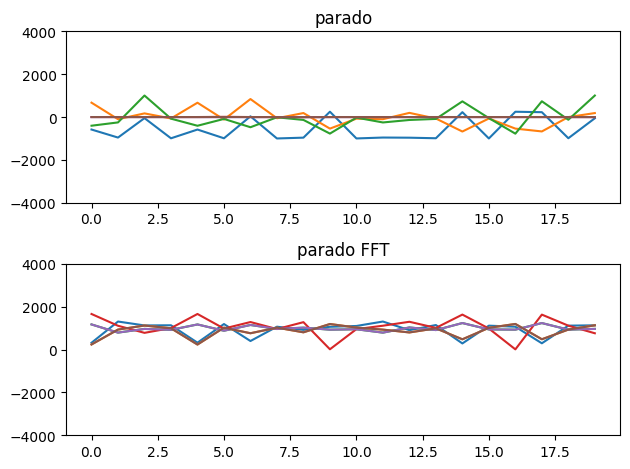

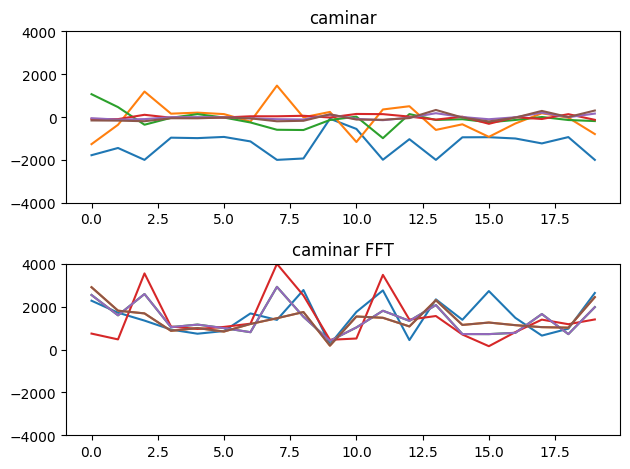

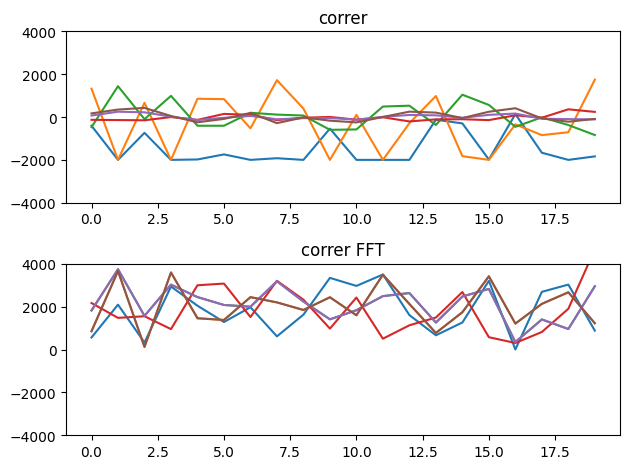

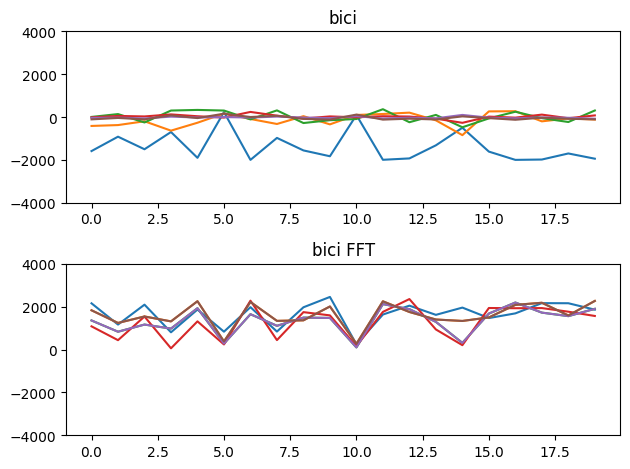

In [27]:
for e in classification.keys():
    graphSamples(e,dataset)

+ ### Arquitectura de la red ###

In [28]:
modelname = input("Introduzca el nombre del modelo \n")

tensorboard = TensorBoard(log_dir='logs/' + modelname,write_graph = True,histogram_freq = True,write_images = True)

modelo = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(16,5, activation='relu', input_shape=(26,3 * nSensor)),
    tf.keras.layers.MaxPooling1D(2),
    
    tf.keras.layers.Conv1D(8,5, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(nMovements, activation="softmax") #nMovements=4  
])

#Compilación
modelo.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', #binary_crossentropy
              metrics=['accuracy'])

Introduzca el nombre del modelo 
 tfg


+ ## Entrenamiento y visualización de resultados
 A continuación, para ver los gráficos y los resultados del entrenamiento, usaremos la herramienta **Tensorboard**, para ello debemos realizar los siguientes pasos:

 > + Desde la consola nos dirigimos a la ruta donde se encuentra la carpeta **logs**.
> + Acto seguido ejecutaremos el comando **tensorboard --logdir nombreModelo**.

In [29]:
epocas=15
history = modelo.fit(
    X,
    Y,
    epochs=epocas,
    validation_data = (Xval,Yval),
    callbacks = [tensorboard]
)
modelo.summary()

Epoch 1/15
169/169 [==============================] - 1s 5ms/step - loss: 1.2170 - accuracy: 0.4536 - val_loss: 0.9542 - val_accuracy: 0.5573
Epoch 2/15
169/169 [==============================] - 1s 3ms/step - loss: 0.6398 - accuracy: 0.7736 - val_loss: 0.2184 - val_accuracy: 0.9979
Epoch 3/15
169/169 [==============================] - 1s 3ms/step - loss: 0.2057 - accuracy: 0.9465 - val_loss: 0.0507 - val_accuracy: 0.9990
Epoch 4/15
169/169 [==============================] - 1s 3ms/step - loss: 0.1047 - accuracy: 0.9742 - val_loss: 0.0151 - val_accuracy: 0.9990
Epoch 5/15
169/169 [==============================] - 1s 3ms/step - loss: 0.0749 - accuracy: 0.9800 - val_loss: 0.0122 - val_accuracy: 0.9990
Epoch 6/15
169/169 [==============================] - 1s 4ms/step - loss: 0.0631 - accuracy: 0.9813 - val_loss: 0.0092 - val_accuracy: 0.9990
Epoch 7/15
169/169 [==============================] - 1s 3ms/step - loss: 0.0564 - accuracy: 0.9835 - val_loss: 0.0069 - val_accuracy: 0.9990
Epoch 

+ Una vez entrenada la red evaluamos la calidad de esta con datos totalmente nuevos.

In [30]:
loss,acc = modelo.evaluate(Xtest,Ytest,verbose = 2)

11/11 - 0s - loss: 0.0045 - accuracy: 1.0000 - 39ms/epoch - 4ms/step


+ A continuación, se define una función para poder realizar una validación desde el STM32CubeIDE, para ello el formato necesario es separar en 2 ficheros distintos las entradas de las salidas.

In [31]:
def auxSTM(mov):
    if nMovements != 2:
        r = np.zeros(nMovements,dtype = int)
        r[mov] = 1
        return r
    else:
        return mov

In [32]:
def savetestSTM():
    stmfolder = "./STM VAL"
    
    if not os.path.exists(stmfolder):
        os.makedirs(stmfolder)
    
    inp = stmfolder + "/" + modelname + "in.csv"
    out = stmfolder + "/" + modelname + "out.csv"
    
    aux = []
    for e in Xtest:
        aux2 = []
        for j in e:
            aux2.extend(j)
        aux.append(aux2)
        
    filein = open(inp,'w',newline = '')
  
    with filein:
        writer = csv.writer(filein)
        writer.writerows(aux)
    filein.close()
    
    auxtest = []
    for e in Ytest:
        aux2 = []
        aux2 = auxSTM(e)
        auxtest.append(aux2)
        
    fileout = open(out,'w',newline = '')
    
    with fileout:
        writer = csv.writer(fileout)
        writer.writerows(auxtest)
    fileout.close() 

In [33]:
savetestSTM()

In [34]:
def savemodel():
    
    modelo.save(modelname + ".h5")
    converter = tf.lite.TFLiteConverter.from_keras_model(modelo)
    tflite_model = converter.convert()

    with open(modelname + ".tflite", 'wb') as f:
        f.write(tflite_model)

In [35]:
savemodel()

INFO:tensorflow:Assets written to: C:\Users\usuario\AppData\Local\Temp\tmpj5kc3baj\assets


INFO:tensorflow:Assets written to: C:\Users\usuario\AppData\Local\Temp\tmpj5kc3baj\assets
